In [1]:
#import de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
#carga de datos
df = pd.read_csv('../datos_simulados/datos_final.csv')
df.head()

,Clase,Pieza,Superficie_1,Superficie_2,Tamanio_cavidad_mm,Estado_cavidad,Tecnica,Tipo_resina,Indice_contraccion_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Ajuste_margen
0,V,32,Bucal,ninguna,3.69,limpia,Bulk,Compuesta,2.0,81.56,8.15,3.64,Equiobturado
1,II,32,Distal,ninguna,2.51,con_tejido,Bulk,Con fibra de vidrio,1.0,143.93,18.62,2.08,Subobturado
2,III,8,Mesial,ninguna,4.11,limpia,Estratificacion,Compuesta,2.0,71.58,9.67,3.98,Equiobturado
3,I,1,Bucal,ninguna,1.04,con_tejido,Estratificacion,Con fibra de vidrio,1.0,110.02,9.04,1.23,Sobreobturado
4,V,25,Lingual,ninguna,1.31,con_tejido,Bulk,Con fibra de vidrio,1.0,118.06,5.29,0.77,Subobturado


In [3]:
# Variables categóricas
columnas_binarias = ['Estado_cavidad']  # limpia, remanente
columnas_onehot = [
    'Superficie_1',       # Bucal, Lingual, etc.
    'Clase',              # I, II, III, IV, V, VI.
    'Tecnica',            # Bulk, Estratificación
    'Tipo_resina',        # Compuesta, Fluida, etc.
    'Ajuste_margen',      # Sobreobt, Subobt, Equiobt
    'Superficie_2'        # Mesial, Distal, ninguna
]

# Rellenar valores nulos en Superficie_2 con 'ninguna'
df.fillna({'Superficie_2': 'ninguna'}, inplace=True)

# Binarizar 'Estado_cavidad'
df['Estado_cavidad'] = df['Estado_cavidad'].map({
    'limpia': 0,
    'con_tejido': 1
})

# Aplicar OneHotEncoder
df_codificado = pd.get_dummies(df, columns=columnas_onehot, dtype=int)

# Mostrar los primeros registros codificados
df_codificado.head()


,Pieza,Tamanio_cavidad_mm,Estado_cavidad,Indice_contraccion_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Superficie_1_Bucal,Superficie_1_Distal,Superficie_1_Incisal,...,Tipo_resina_Bulk,Tipo_resina_Compuesta,Tipo_resina_Con fibra de vidrio,Tipo_resina_Fluida,Ajuste_margen_Equiobturado,Ajuste_margen_Sobreobturado,Ajuste_margen_Subobturado,Superficie_2_Distal,Superficie_2_Mesial,Superficie_2_ninguna
0,32,3.69,0,2.0,81.56,8.15,3.64,1,0,0,...,0,1,0,0,1,0,0,0,0,1
1,32,2.51,1,1.0,143.93,18.62,2.08,0,1,0,...,0,0,1,0,0,0,1,0,0,1
2,8,4.11,0,2.0,71.58,9.67,3.98,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,1,1.04,1,1.0,110.02,9.04,1.23,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,25,1.31,1,1.0,118.06,5.29,0.77,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [4]:
# Variable objetivo: cuánta resina se debe utilizar
#y = df_codificado['Peso_resina_inicial_mg']

# Variables de entrada: eliminamos columnas que no deben usarse para predecir
#X = df_codificado.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg'])
# Crear la nueva variable objetivo: resina realmente utilizada
df_codificado['Resina_utilizada'] = df_codificado['Peso_resina_inicial_mg'] - df_codificado['Peso_sobrante_mg']

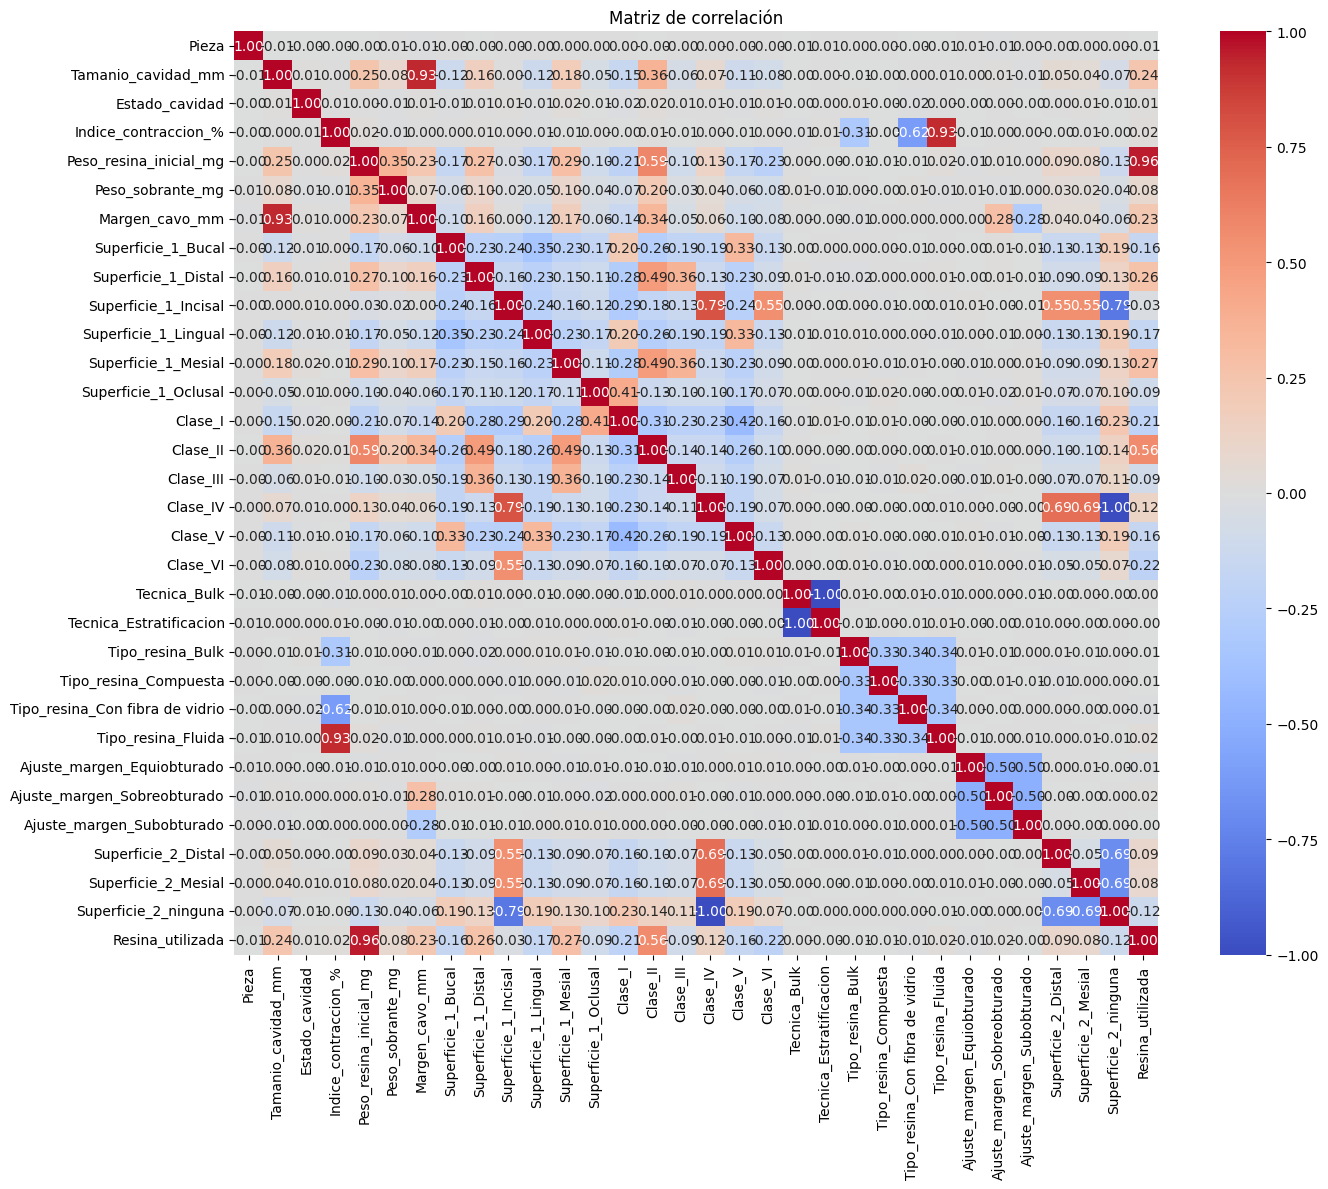

In [5]:
correlacion = df_codificado.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

In [6]:
# Definir variable objetivo
y = df_codificado['Resina_utilizada']
# Eliminar columnas que no deben usarse para predecir
X = df_codificado.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg', 'Resina_utilizada'])

In [7]:
# Dividir los datos en entrenamiento (75%) y prueba (25%)
# test_size=0.25 indica que el 25% de los datos será para prueba
# random_state=42 garantiza que la división siempre sea la misma (para reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
# Realizar predicciones sobre los datos de prueba
y_pred = modelo.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

#métricas de evaluación
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 16.01
R²: 0.36


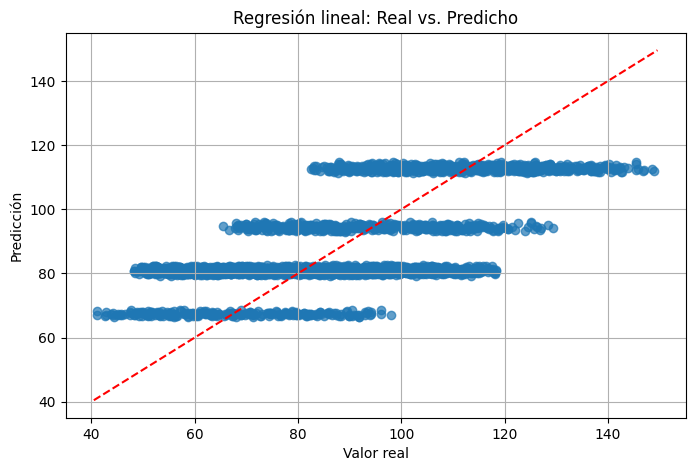

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Regresión lineal: Real vs. Predicho")
plt.grid(True)
plt.show()


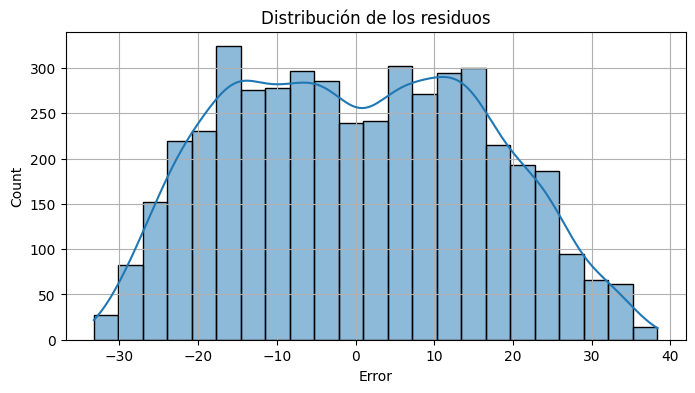

In [11]:
residuos = y_test - y_pred

plt.figure(figsize=(8,4))
sns.histplot(residuos, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Error")
plt.grid(True)
plt.show()

In [12]:
# Realizar predicciones sobre los datos de prueba
y_pred = modelo.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

# Calcular la media del valor real de la resina inicial
media_real = df["Peso_resina_inicial_mg"].mean()

# Calcular el error relativo porcentual
error_relativo_pct = (rmse / media_real) * 100
precision_aproximada = 100 - error_relativo_pct

# Mostrar resultados
print(f"RMSE: {rmse:.2f} mg")
print(f"R²: {r2:.2f}")
print(f"Media real de peso de resina inicial: {media_real:.2f} mg")
print(f"Error relativo aproximado: {error_relativo_pct:.2f} %")
print(f"Precisión aproximada del modelo: {precision_aproximada:.2f} %")

RMSE: 16.01 mg
R²: 0.36
Media real de peso de resina inicial: 96.43 mg
Error relativo aproximado: 16.60 %
Precisión aproximada del modelo: 83.40 %


In [13]:
df_combos = pd.read_csv("../datos_simulados/Combinaciones.csv")
# Mismo preprocesamiento que en entrenamiento
df_combos_codificado = pd.get_dummies(df_combos)
df_combos_codificado = df_combos_codificado.reindex(columns=X_train.columns, fill_value=0)

# Predecir nueva resina inicial
resina_recomendada = modelo.predict(df_combos_codificado)

# Mostrar resultados
for i, valor in enumerate(resina_recomendada.flatten(), start=1):
    print(f"Combinación {i} → Resina inicial recomendada: {valor:.2f} mg")

Combinación 1 → Resina inicial recomendada: 88.52 mg
Combinación 2 → Resina inicial recomendada: 88.52 mg
Combinación 3 → Resina inicial recomendada: 88.52 mg
Combinación 4 → Resina inicial recomendada: 88.50 mg
Combinación 5 → Resina inicial recomendada: 88.50 mg
Combinación 6 → Resina inicial recomendada: 88.50 mg
Combinación 7 → Resina inicial recomendada: 88.48 mg
Combinación 8 → Resina inicial recomendada: 88.48 mg
Combinación 9 → Resina inicial recomendada: 88.48 mg
Combinación 10 → Resina inicial recomendada: 88.46 mg
Combinación 11 → Resina inicial recomendada: 88.46 mg
Combinación 12 → Resina inicial recomendada: 88.46 mg
Combinación 13 → Resina inicial recomendada: 88.45 mg
Combinación 14 → Resina inicial recomendada: 88.45 mg
Combinación 15 → Resina inicial recomendada: 88.45 mg
Combinación 16 → Resina inicial recomendada: 88.43 mg
Combinación 17 → Resina inicial recomendada: 88.43 mg
Combinación 18 → Resina inicial recomendada: 88.43 mg
Combinación 19 → Resina inicial recom